In [88]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from diffuse import datasets
from dataclasses import dataclass
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

from diffuse.models import MLP
from diffuse.noise_scheduler import NoiseScheduler
%load_ext autoreload
%autoreload 2

@dataclass
class Config:
    experiment_name: str = 'base'
    dataset: str = 'dino'
    train_batch_size: int = 128
    eval_batch_size: int = 1000
    num_epochs: int = 20
    learning_rate: float = 1e-3
    num_timesteps: int = 50
    beta_schedule: str = "log2"
    embedding_size: int = 128
    hidden_size: int = 128
    hidden_layers: int = 3
    time_embedding: str = "sinusoidal"
    input_embedding: str = "sinusoidal"
    save_images_step: int = 1

config = Config()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training

In [90]:
device = torch.device('cpu')
dataset = datasets.get_dataset('moons')

dataloader = DataLoader(
    dataset, batch_size=config.train_batch_size, shuffle=True, drop_last=True)

model = MLP(
    hidden_size=config.hidden_size,
    hidden_layers=config.hidden_layers,
    emb_size=config.embedding_size,
    time_emb=config.time_embedding,
    input_emb=config.input_embedding).to(device)

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_schedule=config.beta_schedule)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

global_step = 0
losses = []
epoch_to_samples = dict()

print("Training model...")

for epoch in range(config.num_epochs):
    model.train()
    for step, batch in enumerate(dataloader):
        batch = batch[0]
        noise = torch.randn(batch.shape)
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noise_pred = model(noisy.to(device), timesteps.to(device))
        loss = F.mse_loss(noise_pred, noise.to(device))
        optimizer.zero_grad()
        loss.backward(loss)

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        losses.append(float(loss.detach().item()))

        # progress_bar.set_postfix(**logs)
        if global_step % 300 == 0:
            loss = sum(losses[-30:])/min(30,len(losses)) # running loss
            print(f'e{epoch}|s{global_step} loss={loss:.2f}')

        global_step += 1

    if epoch % config.save_images_step == 0 or epoch == config.num_epochs - 1:
        epoch_to_samples[epoch]=model.sample(noise_scheduler)

Training model...
e0|s0 loss=0.80
e4|s300 loss=0.77
e9|s600 loss=0.74
e14|s900 loss=0.76
e19|s1200 loss=0.74


## Sampling

(-6.0, 6.0)

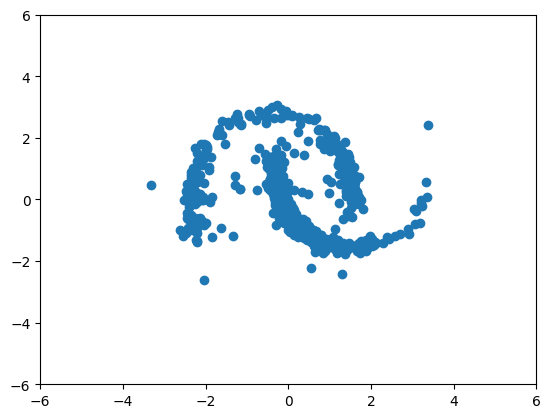

In [101]:
fig,ax = plt.subplots()
s = epoch_to_samples[16][40]
ax.scatter(s[:,0],s[:,1])
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)

In [102]:
# print("Saving model...")
# outdir = f"exps/{config.experiment_name}"
# os.makedirs(outdir, exist_ok=True)
# torch.save(model.state_dict(), f"{outdir}/model.pth")

# print("Saving images...")
# imgdir = f"{outdir}/images"
# os.makedirs(imgdir, exist_ok=True)
# frames = np.stack(frames)
# xmin, xmax = -6, 6
# ymin, ymax = -6, 6
# for i, frame in enumerate(frames):
#     plt.figure(figsize=(10, 10))
#     plt.scatter(frame[:, 0], frame[:, 1])
#     plt.xlim(xmin, xmax)
#     plt.ylim(ymin, ymax)
#     plt.savefig(f"{imgdir}/{i:04}.png")
#     plt.close()

# print("Saving loss as numpy array...")
# np.save(f"{outdir}/loss.npy", np.array(losses))

# print("Saving frames...")
# np.save(f"{outdir}/frames.npy", frames)

In [110]:
x = dataset.tensors[0]

In [118]:
emb.shape

torch.Size([8000, 2, 50])

In [120]:
emb.shape

torch.Size([50])

In [128]:
(emb.unsqueeze(0) * x.unsqueeze(-1)).shape

torch.Size([8000, 2, 50])

In [135]:
x.unsqueeze(-1).shape, emb.unsqueeze(0).shape

(torch.Size([8000, 2, 1]), torch.Size([1, 50]))

In [138]:
size=100
half_size = size // 2
emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
emb = torch.exp(-emb * torch.arange(half_size))
# (B,2,1) * (1,50)
emb = x.unsqueeze(-1) * emb.unsqueeze(0)
emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
# plt.plot(emb)

In [139]:
emb.shape

torch.Size([8000, 2, 100])

tensor([0.1880])